In [1]:
# !pip install swifter
# !pip install tensorflow==2.0.0
# !pip install kagglehub
# !pip install opencv-python

In [33]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import kagglehub
import cv2
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalMaxPooling2D
import swifter
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold import TSNE
import time
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances
# tf.__version__

In [3]:
# load the data
dataset_path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
print("Path to dataset files:", dataset_path)

Path to dataset files: C:\Users\RY-LU\.cache\kagglehub\datasets\paramaggarwal\fashion-product-images-small\versions\1


In [4]:
df = pd.read_csv(r"\Users\RY-LU\.cache\kagglehub\datasets\paramaggarwal\fashion-product-images-small\versions\1\styles.csv", nrows=5000)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


In [5]:
image_dir = r"\Users\RY-LU\.cache\kagglehub\datasets\paramaggarwal\fashion-product-images-small\versions\1\images"

def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    # plt.tight_layout()
    
def img_path(img_name):
    return os.path.join(image_dir, img_name)

def load_image(image_name, scale_factor=2):
    image_path = os.path.join(image_dir, image_name)
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Unable to load {image_path}")
        return None
    img = cv2.resize(img, (img.shape[1]*scale_factor, img.shape[0]*scale_factor), interpolation = cv2.INTER_CUBIC)
    return img

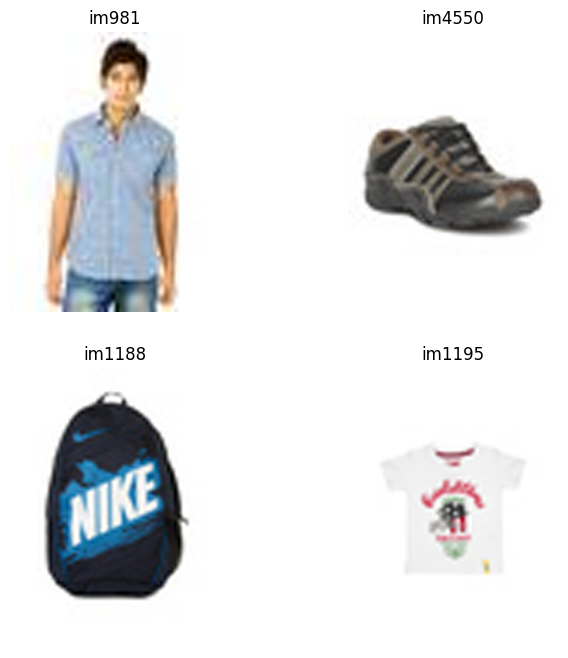

In [6]:
# generation of a dictionary of title and image pairs
figures = {}
for i, row in df.sample(4).iterrows():
    img = load_image(row.image, scale_factor=4)
    if img is not None:
        figures['im' + str(i)] = img
    else:
        print(f"Skipping {row.image}, as it could not be loaded.")

if figures:
    plot_figures(figures, 2, 2)
else:
    print("No valid images to display.")

<Axes: ylabel='articleType'>

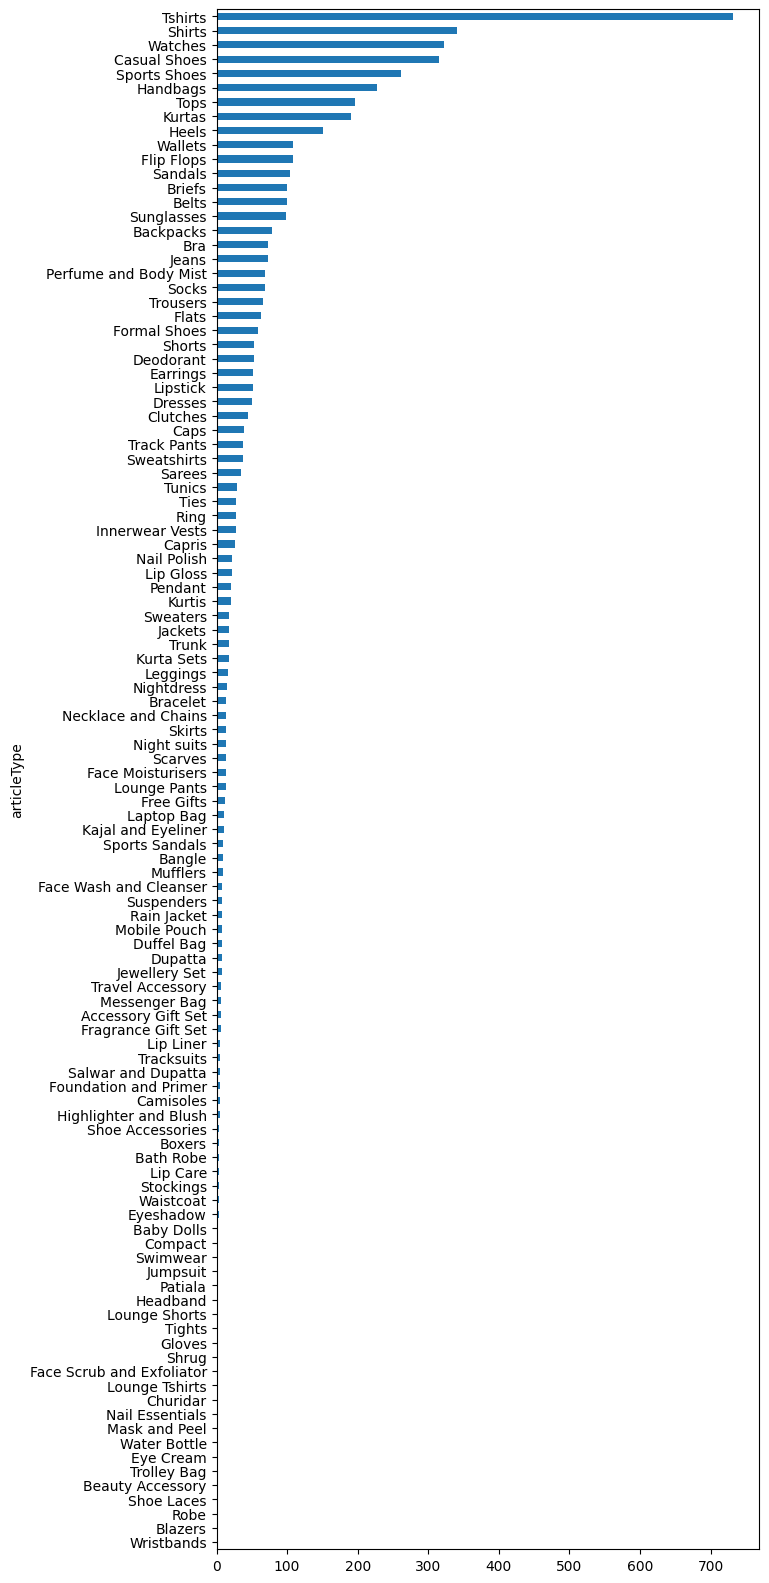

In [7]:
plt.figure(figsize=(7,20))
df.articleType.value_counts().sort_values().plot(kind='barh')

In [8]:
# image shape
load_image(df.iloc[0].image).shape

(160, 120, 3)

In [9]:
img_width, img_height, _ = load_image(df.iloc[0].image).shape

In [10]:
# baseline model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# add Layer Embedding
model = tf.keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 5, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 2048)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
def get_embedding(model, img_name):
    # if lists of filenames
    if isinstance(img_name, list):
        # keep the first image
        img_name = img_name[0]

    img_path_full = img_path(img_name)
    print(f"Loading image from: {img_path_full}")

    if not os.path.exists(img_path_full):
        raise FileNotFoundError(f"Image not found: {img_path_full}")
    # image loading and preprocessing
    img = image.load_img(img_path_full, target_size=(img_width, img_height))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # extract features using the model
    embedding = model.predict(x)
    return embedding.flatten()

In [12]:
emb = get_embedding(model, df.iloc[1].image)
emb.shape

Loading image from: \Users\RY-LU\.cache\kagglehub\datasets\paramaggarwal\fashion-product-images-small\versions\1\images\39386.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


(2048,)

[ 1.5296357  9.578047   0.        ...  0.         2.7994661 12.164832 ]


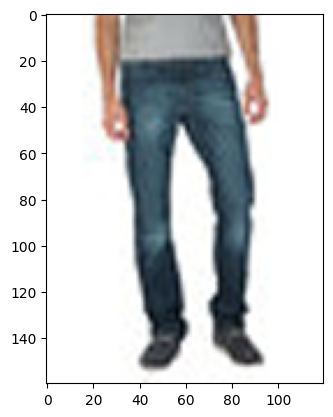

In [13]:
plt.imshow(cv2.cvtColor(load_image(df.iloc[1].image), cv2.COLOR_BGR2RGB))
print(emb)

In [14]:
# get embeddings for all images in the dataset
map_embeddings = df['image'].swifter.apply(lambda img: get_embedding(model, img))
df_embs = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()

Pandas Apply:   0%|          | 0/5000 [00:00<?, ?it/s]

Loading image from: \Users\RY-LU\.cache\kagglehub\datasets\paramaggarwal\fashion-product-images-small\versions\1\images\15970.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Loading image from: \Users\RY-LU\.cache\kagglehub\datasets\paramaggarwal\fashion-product-images-small\versions\1\images\39386.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Loading image from: \Users\RY-LU\.cache\kagglehub\datasets\paramaggarwal\fashion-product-images-small\versions\1\images\59263.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Loading image from: \Users\RY-LU\.cache\kagglehub\datasets\paramaggarwal\fashion-product-images-small\versions\1\images\21379.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Loading image from: \Users\RY-LU\.cache\kagglehub\datasets\paramaggarwal\fashion-product-images-small\versions\1\images\53759.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Loading image from: \Users\RY-LU\.cache\kagglehub\datasets\paramaggarwal\fashion-product-images-small\versions\1\images\1855.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70m

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.000000,12.462460,0.000000,7.832366,0.000000,1.859507,6.395232,1.407238,0.077494,3.861750,...,0.510538,0.000000,0.000000,10.859614,0.000000,0.000000,4.673603,1.600465,0.000000,14.868223
1,1.529636,9.578047,0.000000,4.870188,4.533106,0.000000,5.917154,3.956744,5.292252,0.000000,...,0.335625,1.015429,6.421992,6.572658,0.000000,0.424392,1.139615,0.000000,2.799466,12.164832
2,0.000000,2.552261,0.000000,5.590761,0.000000,0.000000,0.068461,0.000000,0.000000,2.060171,...,0.000000,8.771423,0.000000,0.000000,0.000000,0.000000,1.787922,3.031862,12.936445,4.498510
3,1.046249,8.006062,0.000000,10.717419,2.404273,1.282154,3.641376,12.456106,2.484679,0.538830,...,20.230307,0.000000,1.321332,0.038303,0.890105,0.406056,0.996703,0.000000,12.094875,10.560665
4,0.000000,15.332243,0.341316,4.344475,2.679124,0.000000,4.537621,2.886402,5.081916,0.967013,...,1.918570,0.000000,0.000000,8.719247,1.895671,0.000000,3.764112,4.037905,0.376687,10.122682


In [15]:
# find cosine similarity of all item pairs
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')

In [42]:
indices = pd.Series(range(len(df)), index=df.index)
# recommendations based on the cosine similarity score
def get_recommender(idx, df, top_n = 5):
    sim_idx = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec = [i[0] for i in sim_scores]
    idx_sim = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim
    
def precision_at_k(actual_items, recommended_items, k):
    recommended_items = recommended_items[:k]
    relevant_items = set(actual_items)
    retrieved_relevant = sum(1 for item in recommended_items if item in relevant_items)
    return retrieved_relevant / k

In [38]:
# from sklearn.metrics.pairwise import euclidean_distances

# # Compute Euclidean distance
# euclidean_sim = 1 / (1 + euclidean_distances(df_embs))
# def get_recommender_euclidean(idx, df, top_n=5):
#     sim_idx = indices[idx]
#     sim_scores = list(enumerate(euclidean_sim[sim_idx]))
#     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#     sim_scores = sim_scores[1:top_n+1]  # Skip itself
#     idx_rec    = [i[0] for i in sim_scores]
#     idx_sim    = [i[1] for i in sim_scores]
    
#     return indices.iloc[idx_rec].index, idx_sim
    
from scipy.spatial.distance import correlation

# Pearson correlation similarity
pearson_sim = 1 - pairwise_distances(df_embs, metric="correlation")
def get_recommender_pearson(idx, df, top_n=5):
    sim_idx = indices[idx]
    sim_scores = list(enumerate(pearson_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim


In [17]:
get_recommender(2993, df, top_n = 5)

(Index([3349, 3899, 1389, 2400, 1107], dtype='int64'),
 [0.9085038, 0.8976339, 0.8928908, 0.89084727, 0.890147])

In [27]:
np.mean(get_recommender(2993, df, top_n = 5)[1])

0.8960045

In [45]:
get_recommender(2993, df, top_n = 5)[0]

Index([3349, 3899, 1389, 2400, 1107], dtype='int64')

In [47]:
# actual_items = [2993]
# recommended_items = get_recommender(2993, df, top_n = 5)[0]
# precision_at_k(actual_items, recommended_items, 5)

the precision score calculation doesnot quite make sense here since we do not have labels for similar items in the original data. 

In [39]:
# peason
get_recommender_pearson(2993, df, top_n = 5)

(Index([3349, 3899, 1389, 2400, 1107], dtype='int64'),
 [0.8650265371627683,
  0.8524393783777264,
  0.8470978294632527,
  0.8448491151178743,
  0.8446940833560352])

In [40]:
np.mean(get_recommender_pearson(2993, df, top_n = 5)[1])

0.8508213886955314

In [24]:
get_recommender(2365, df, top_n = 5)

(Index([4725, 1236, 2103, 2343, 96], dtype='int64'),
 [0.97838867, 0.86258006, 0.86123794, 0.85999995, 0.8583709])

In [28]:
np.mean(get_recommender(2365, df, top_n = 5)[1])

0.8841155

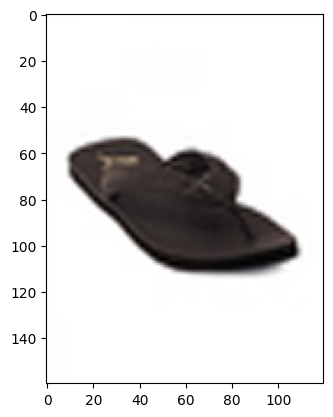

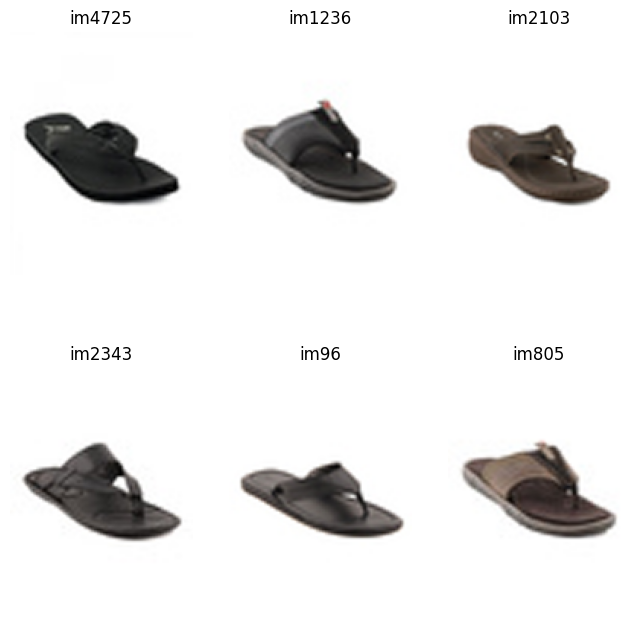

In [18]:
idx_ref = 2365

# recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

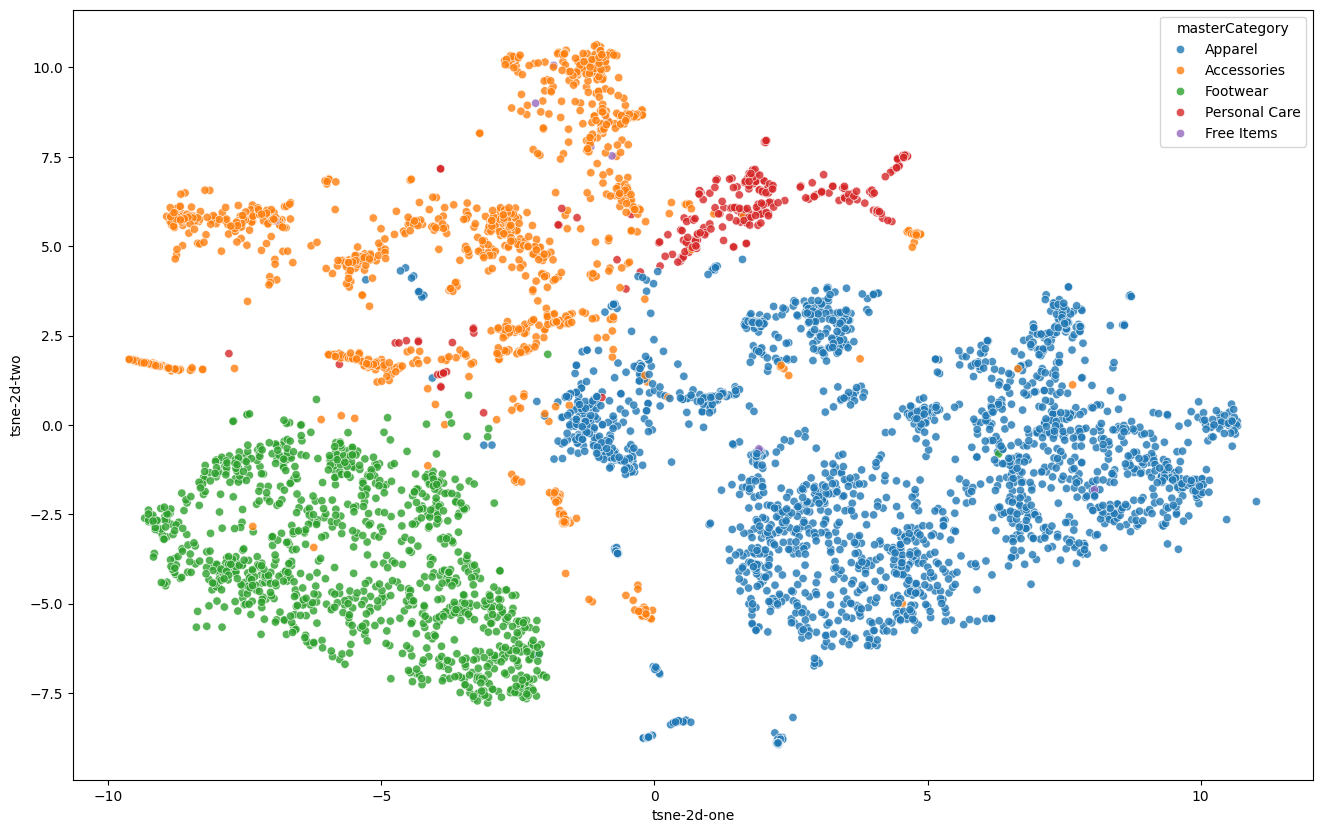

In [20]:
# latent space
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embs)
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory", #subCategory
                data=df,
                legend="full",
                alpha=0.8)